# Problem 1

## Finite Difference Scheme: Heating in Electronic Semiconductor Circuits

# Fourier Heat Conduction Equation Analysis

The Fourier heat conduction equation in 1D space is given by:

$$
\frac{\partial}{\partial t} (\rho c_p T) = \frac{\partial}{\partial x} \left( k(T) \frac{\partial T}{\partial x} \right)
$$

where $k(T)$ is the temperature-dependent thermal conductivity of SILVER. We can find $k(T)$, through regression (such as a polynomial fit) of temperature versus thermal conductivity data. It's crucial to remember that $k(T)$ is not a constant and should be considered a function of $T$ it introduces Non-Linearity in the system under Analysis.

We will consider the density $\rho$ and specific heat capacity $c_p$ as constant for SILVER.

## Initial and Boundary Conditions

The initial and boundary conditions for the problem are givtn as:

- At $t = 0$, $T = T_0 = 300 K$
- At $x = 0$, $T = T_0[1 + \sin(2 \pi f t)]$ where $f$ is the frequency of the fluctuation. This condition is relevant for the heating of electric-vehicle charging ports connected to an AC source.
- At $x = L = 1$ $cm $, $T = T_0$ (constant)


## Calculation

For Calculation of Part $a$, $b$ and $c$ we need to obtain the temperature profile $T(x = 0.25L, t)$, $T(x = 0.5L, t)$, $T(x = 0.75L, t)$, and $T(x = L, t)$, using the given conditions and understanding of the Fourier heat conduction equation.

Let's begin by defining the problem parameters, including the thermal conductivity $k(T)$, and setting up the initial and boundary conditions for our analysis.

In [ ]:
# Libarary needed for the Problem
import numpy as np
import math
import time
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

## Problem constant and Intial Condition and Boundary Condition

The Constant $\rho$ and $c_p$ for the above problem are obatined from here - [Constants data of silver](https://www.efunda.com/materials/elements/element_info.cfm?Element_ID=Ag)

In [ ]:
T_0 = 300 # Boundary Temperature (K)
L = 0.1 # Length of Bar under consideration (m)

rho = 10500 # Density of Silver (SI Unit)
c_p = 235 # Specific heat Capacity of Silver (SI Unit)

## Defining Thermal Conductivity as a Function of Temperature

By doing a regression with the obtained Data of Thermal conductivity variation with Temperature which is obtained from the given website:
[Thermal conductivity data of silver](https://www.efunda.com/materials/elements/TC_Table.cfm?Element_ID=Ag)

The thermal conductivity, $k(T)$, is defined through a3 degree  polynomial relationship with respect to temperature, $T$. This relationship is represented by the function `kc(T)` in our code. Similarly, the derivative of thermal conductivity with respect to temperature, which is needed for certain analytical and numerical methods, is defined by the function `kc_(T)`.

In [ ]:
# Thermal conductivtity of the material as a function Temperature
def kc(T: float) -> float:
  '''
  For the varying thermal conductivity of the metal
  '''
  a_0, a_1, a_2, a_3 = 7.894997e-8, -1.91111e-4, 0.06812, 423.12
  return a_0 * T**3 + a_1 * T**2 + a_2 * T + a_3

# Thermal conductivtity derivative of the material as a function Temperature
def kc_(T: float) -> float:
  '''
  For the varying thermal conductivity derivative of the metal
  '''
  a_0, a_1, a_2 = 7.894997e-8, -1.91111e-4, 0.06812
  return 3 * a_0 * T**2 + 2 * a_1 * T + a_2

## Implementation of the Explicit Scheme for Heat Conduction

In this section, we implement the explicit scheme to solve the Fourier heat conduction equation for silver, considering its temperature-dependent thermal conductivity. The explicit method, a time-stepping scheme, allows us to compute the temperature profile over a specified domain and time frame.

### Discretizing the Equation:

$$
(\rho c_p)\frac{T_{i}^{N+1} - T_{i}^{N}}{\Delta t} = k(T_{i}^{N})\frac{T_{i-1}^{N} - 2T_{i}^{N} + T_{i-1}^{N}}{(\Delta x)^2} + k^{'}(T_{i}^{N})\left( \frac{T_{i+1}^{N}-T_{i-1}^{N}}{\Delta x}\right)^2
$$

### Initial Setup

- **Frequency**: The simulation incorporates a frequency `w = 1` for the boundary condition at `x = 0`, which models the sinusoidal variation in temperature.
- **Time Steps**: We define a small time step `dt = 0.001` to ensure numerical stability and accuracy. The total simulation time is slightly over 5 seconds, adjusted for the frequency of temperature fluctuation.
- **Spatial Nodes**: The domain is discretized into `Nx = 4` nodes, with `dx` being the distance between each node. This granularity allows us to capture the temperature gradient across the domain.

### Numerical Parameters and Initial Conditions

- **Lambda**: A crucial parameter for the explicit scheme, `Lambda = dt/(rho*c_p*(dx**2))`, ensures the numerical stability of the method under the chosen discretization.
- **Temperature Matrix**: We initialize a temperature matrix `T_matrix` to store temperature values at each spatial node and time step. This matrix is populated with initial and boundary conditions:
  - The initial temperature profile is set to `T_0` across the domain.
  - At `x = 0`, a dynamic boundary condition models the sinusoidal temperature variation.
  - The temperature at the domain's end, `x = L`, is kept constant at `T_0`.

### Simulation Loop

The core of the simulation iterates over each time step, upating the temperature at each node based on the explicit scheme formula. It accounts for the temperature-dependent thermal conductivity `kc(T)` and its derivative `kc_(T)` to accurately model the heat conduction process. The update equation incorporates both the conduction term and a correction term derived from the conductivity's temperature dependency.

### Results

The simulation outputs the temperature matrix `T_matrix`, showcasing how the temperature evolves over time and space within the domain. This matrix is pivotal for analyzing the temperature profile's behavior under the given initial and boundary conditions, particularly for applications like heating in electric-vehicle charging ports.



In [ ]:
# Explicit Scheme
w = 1 # frequency

# No. of Time_steps
dt = 0.001
total_sim_time = 5 + dt # Based on the frequency
Nt = int(round(total_sim_time/float(dt)))
t_mesh = np.linspace(0, total_sim_time, Nt+1)   # mesh points in time

# No. of Nodes
Nx = 4
dx = L/Nx

Lambda = dt/(rho*c_p*(dx**2))
# print(Lambda)
T_matrix = np.zeros((len(t_mesh), Nx+1))
# print(np.array(T_matrix).shape)
# Initailizing the Initial condition and Boundary Condition
T_matrix[0,1:-1] = T_0 # Intial Condition
T_matrix[0,0] = 2 * T_0 # x = 0, Boundary Condition
T_matrix[:,-1] = T_0
# print(T_matrix)

for t in range(1, len(t_mesh)-1):
    T_matrix[t,0] = T_0 * (2 + np.sin(2*np.pi*w*t_mesh[t]))
    for i in range(1,Nx):
        T_matrix[t,i] = T_matrix[t-1,i] + Lambda * (kc(T_matrix[t-1,i]) * (T_matrix[t-1,i+1] - 2 * T_matrix[t-1,i] + T_matrix[t-1,i-1]) + kc_(T_matrix[t-1,i]) * (T_matrix[t-1,i+1] - T_matrix[t-1,i-1])**2)
print(T_matrix[:-1,:])

[[600.         300.         300.         300.         300.        ]
 [601.88494319 300.08188083 300.         300.         300.        ]
 [603.76981197 300.16421975 300.00002275 300.         300.        ]
 ...
 [596.23018803 445.13878085 367.82879207 322.43534983 300.        ]
 [598.11505681 445.15713241 367.83721888 322.44162831 300.        ]
 [600.         445.17596175 367.84564773 322.44790561 300.        ]]


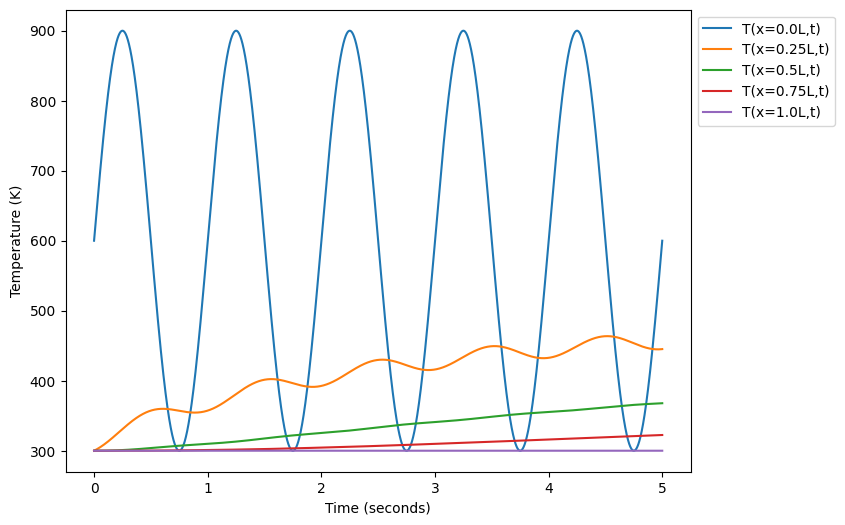

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))  # Adjusts the figure size
for i in range(T_matrix.shape[1]):
    plt.plot(t_mesh[:-1], T_matrix[:-1, i], label=f'T(x={i*0.25}L,t)')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.subplots_adjust(right=0.75)  # Adjust the right margin to make room for the legend
plt.show()

## Implementation of the Implicit Scheme for Heat Conduction

This section outlines the implementation of the implicit scheme to address the Fourier heat conduction equation in materials with temperature-dependent thermal conductivity. Unlike the explicit method, the implicit scheme allows for greater stability at larger time steps, making it suitable for long-duration simulations.

### Overview of the Implicit Scheme

The implicit method solves the heat equation by treating future time steps as unknowns in the system of equations. This approach inherently stabilizes the numerical method, allowing for larger time step sizes without sacrificing stability. However, it requires solving a system of equations at each time step, often necessitating more computational resources than explicit methods.

### Initial Setup and Discretization

- **Frequency and Initial Conditions**: Similar to the explicit scheme, we set a frequency `w = 1` for a dynamic boundary condition and initialize the temperature profile to `T_0` across the domain. The boundary conditions include a sinusoidal variation at `x = 0` and a constant temperature `T_0` at the domain's end.
- **Spatial and Temporal Discretization**: The domain is divided into `Nx = 4` spatial nodes with a spacing of `dx`, and the simulation spans a time frame slightly over 5 seconds(for not getting out of the bound array issue) with a time step `dt = 0.1`. This discretization captures the spatial temperature gradient and temporal evolution.

### Numerical Implementation

- **TDMA Solver**: To handle the linear system arising from the implicit scheme, we employ the Tri-Diagonal Matrix Algorithm (TDMA), which efficiently solves tridiagonal systems of equations. This method is critical for updating the temperature profile at each time step.
- **Temperature Matrix Initialization**: A temperature matrix `T_matrix` is initialized to store the computed temperatures at each node for every time step, incorporating both initial and boundary conditions.

### Iterative Solution Process

- **Constructing the System**: At each time step, we construct a tridiagonal system representing the discretized heat equation. This system accounts for the temperature-dependent thermal conductivity and its derivative, ensuring accurate modeling of the physical process.
- **TDMA Application**: The TDMA solver is applied to solve the tridiagonal system, yielding the temperature profile for the next time step. This process is repeated, iteratively updating the temperature matrix.

### Results and Analysis

- **Temperature Matrix Output**: The final output is the temperature matrix `T_matrix`, which provides a comprehensive view of how the temperature distribution evolves over time across the spatial domain. This information is crucial for understanding the heat transfer dynamics under various boundary and initial conditions.

### Conclusion

The implicit scheme's ability to handle larger time steps without compromising stability makes it a valuable tool in simulations where computational efficiency and long-term stability are paramount. Through careful implementation and analysis, we can gain insights into the thermal behavior of materials and processes, aiding in the design and optimization of systems where heat transfer is a critical factor.


In [ ]:
# Here a = Lower Diag, b = Main Diag, c = Upper Diag, d = solution vector
def TDMA(a,b,c,d):
    n = len(d) #
    w= np.zeros(n-1,float)
    g= np.zeros(n, float)
    p = np.zeros(n,float)

    w[0] = c[0]/b[0] # q_1
    g[0] = d[0]/b[0] # p_1

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p


import numpy as np
T_0 = 300
w = 1
L = 0.1
Nx = 4 # Number of divisions

theta = 1  # A Genearal parameter value for transition between explicit and Implicit
x_mesh = np.linspace(0, L, Nx+1)   # mesh points in space / redundant
dx = x_mesh[1] - x_mesh[0]
dt = 0.1
t_sim = 5 + dt

rho = 10500 # Please check
c_p = 235 # Please check

Nt = int(round(t_sim/float(dt)))
t_mesh = np.linspace(0, t_sim, Nt+1)   # mesh points in tim

# Representation of sparse matrix and right-hand side
diagonal = np.zeros(Nx+1)
lower    = np.zeros(Nx+1)
upper    = np.zeros(Nx+1)
b        = np.zeros(Nx+1)

# Jacobian computing

Lambda = dt/(2*rho*c_p*(dx**2))
T_matrix = np.zeros((len(t_mesh), len(x_mesh)))
T_matrix[0,0] = 2 * T_0 # x = 0, Boundary Condition
T_matrix[:, -1] = T_0
T_matrix[0,1:-1] = T_0


for t in range(1, len(t_mesh)-1):
  T_matrix[t,0] = T_0 * (2 + np.sin(2*np.pi*w*t_mesh[t]))
  T_n = np.copy(T_matrix[t,:])

  T_n[1:-1] = np.copy(T_matrix[t-1,1:-1])
  T_matrix[t,1:-1] = np.copy(T_n[1:-1])

  for _ in range(0,3):
    for i in range(1,Nx):
      k_minus, k, k_plus, kd_minus, kd, kd_plus   = kc(T_n[i-1]),kc(T_n[i]),kc(T_n[i+1]), kc_(T_n[i-1]), kc_(T_n[i]), kc_(T_n[i+1])
      diagonal[i] = 1 - theta*Lambda*(kd*(T_n[i-1] - 2 * T_n[i] + T_n[i+1]) - (k_minus + 2*k + k_plus))
      lower[i-1] = - theta*Lambda*(kd_minus*(T_n[i-1] - T_n[i]) + (k_minus + k))
      upper[i+1] = - theta*Lambda*(kd_plus*(-T_n[i] + T_n[i+1]) + (k + k_plus))

      b[i] = - (T_n[i] - theta*Lambda*(k_minus*(T_n[i-1] - T_n[i]) + k*(T_n[i-1] - 2*T_n[i] + T_n[i+1]) + k_plus*(-T_n[i] + T_n[i+1])) \
              - T_matrix[t-1,i] - (1 - theta)*Lambda*(kc(T_matrix[t-1,i-1])*(T_matrix[t-1,i-1] - T_matrix[t-1,i]) + \
                                                    kc(T_matrix[t-1,i])*(T_matrix[t-1,i-1] - 2*T_matrix[t-1,i] + T_matrix[t-1,i+1]) + \
                                                    kc(T_matrix[t-1,i+1])*(-T_matrix[t-1,i] + T_matrix[t-1,i+1])))

    T_pr = TDMA(lower[1:-2],diagonal[1:-1], upper[2:-1], b[1:-1])

    T_n[1:-1] = np.copy([T_dif + T_int for T_dif, T_int in zip(T_pr, T_n[1:-1])])
    # print(T_n, len(T_n))

  T_matrix[t,:] = np.copy(T_n)

print(T_matrix[:-1,:])

[[600.         300.         300.         300.         300.        ]
 [776.33557569 312.10378085 300.31869368 300.00838849 300.        ]
 [885.31695489 326.19904336 300.99182408 300.03405266 300.        ]
 [885.31695489 339.58859307 301.98245359 300.08443858 300.        ]
 [776.33557569 349.705924   303.18844068 300.16391079 300.        ]
 [600.         354.97102234 304.4718516  300.27297318 300.        ]
 [423.66442431 355.47153405 305.70441982 300.40872758 300.        ]
 [314.68304511 353.1222378  306.8147146  300.56654932 300.        ]
 [314.68304511 350.92242395 307.8135491  300.74234235 300.        ]
 [423.66442431 351.71625088 308.78570235 300.93445712 300.        ]
 [600.         357.01779604 309.8511971  301.14448839 300.        ]
 [776.33557569 366.43658432 311.11344644 301.37666655 300.        ]
 [885.31695489 378.01810021 312.61914007 301.63622601 300.        ]
 [885.31695489 389.04446926 314.34143157 301.92741771 300.        ]
 [776.33557569 396.93184135 316.18757369 302.251

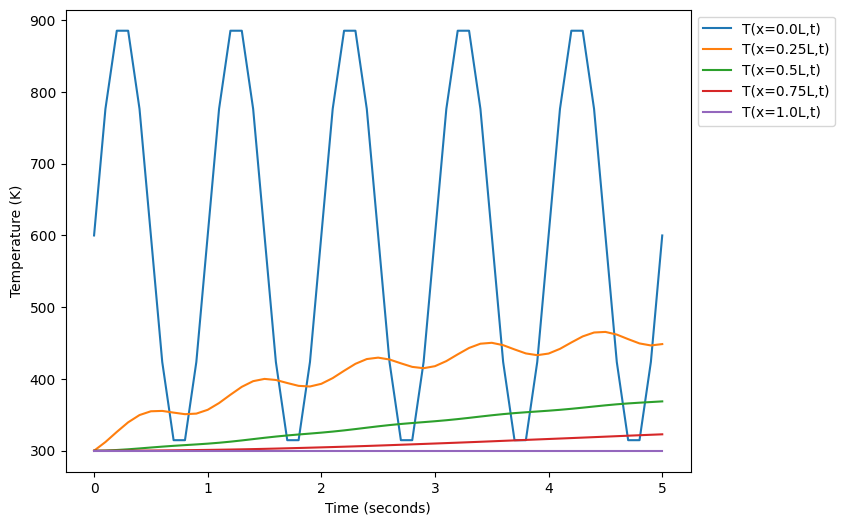

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))  # Adjusts the figure size
for i in range(T_matrix.shape[1]):
    plt.plot(t_mesh[:-1], T_matrix[:-1, i], label=f'T(x={i*0.25}L,t)')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.subplots_adjust(right=0.75)  # Adjust the right margin to make room for the legend
plt.show()

In [ ]:
# Here a = Lower Diag, b = Main Diag, c = Upper Diag, d = solution vector
def TDMA(a,b,c,d):
    n = len(d) # 9
    w= np.zeros(n-1,float)
    g= np.zeros(n, float)
    p = np.zeros(n,float)

    w[0] = c[0]/b[0] # q_1
    g[0] = d[0]/b[0] # p_1

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p


T_0 = 300
w = 1
L = 0.1
Nx = 4 # Number of divisions

theta = 0.5  # this is the parameter value for Crank Nicholson Scheme
x_mesh = np.linspace(0, L, Nx+1)   # mesh points in space / redundant
dx = x_mesh[1] - x_mesh[0]
dt = 0.1
t_sim = 5 + dt

rho = 10500 # Please check
c_p = 235 # Please check

Nt = int(round(t_sim/float(dt)))
t_mesh = np.linspace(0, t_sim, Nt+1)   # mesh points in tim

# Representation of sparse matrix and right-hand side
diagonal = np.zeros(Nx+1)
lower    = np.zeros(Nx+1)
upper    = np.zeros(Nx+1)
b        = np.zeros(Nx+1)

# Jacobian computing

Lambda = dt/(2*rho*c_p*(dx**2))
T_matrix = np.zeros((len(t_mesh), len(x_mesh)))
T_matrix[0,0] = 2 * T_0 # x = 0, Boundary Condition
T_matrix[:, -1] = T_0
T_matrix[0,1:-1] = T_0


for t in range(1, len(t_mesh)-1):
  T_matrix[t,0] = T_0 * (2 + np.sin(2*np.pi*w*t_mesh[t]))
  T_n = np.copy(T_matrix[t,:])

  T_n[1:-1] = np.copy(T_matrix[t-1,1:-1])
  T_matrix[t,1:-1] = np.copy(T_n[1:-1])

  for _ in range(0,5):
    for i in range(1,Nx):
      k_minus, k, k_plus, kd_minus, kd, kd_plus   = kc(T_n[i-1]),kc(T_n[i]),kc(T_n[i+1]), kc_(T_n[i-1]), kc_(T_n[i]), kc_(T_n[i+1])
      diagonal[i] = 1 - theta*Lambda*(kd*(T_n[i-1] - 2 * T_n[i] + T_n[i+1]) - (k_minus + 2*k + k_plus))
      lower[i-1] = - theta*Lambda*(kd_minus*(T_n[i-1] - T_n[i]) + (k_minus + k))
      upper[i+1] = - theta*Lambda*(kd_plus*(-T_n[i] + T_n[i+1]) + (k + k_plus))

      b[i] = - (T_n[i] - theta*Lambda*(k_minus*(T_n[i-1] - T_n[i]) + k*(T_n[i-1] - 2*T_n[i] + T_n[i+1]) + k_plus*(-T_n[i] + T_n[i+1])) \
              - T_matrix[t-1,i] - (1 - theta)*Lambda*(kc(T_matrix[t-1,i-1])*(T_matrix[t-1,i-1] - T_matrix[t-1,i]) + \
                                                    kc(T_matrix[t-1,i])*(T_matrix[t-1,i-1] - 2*T_matrix[t-1,i] + T_matrix[t-1,i+1]) + \
                                                    kc(T_matrix[t-1,i+1])*(-T_matrix[t-1,i] + T_matrix[t-1,i+1])))

    T_pr = TDMA(lower[1:-2],diagonal[1:-1], upper[2:-1], b[1:-1])

    T_n[1:-1] = np.copy([T_dif + T_int for T_dif, T_int in zip(T_pr, T_n[1:-1])])
    # print(T_n, len(T_n))

  T_matrix[t,:] = np.copy(T_n)

print(T_matrix[:-1,:])

[[600.         300.         300.         300.         300.        ]
 [776.33557569 310.19062426 300.13772501 300.00186157 300.        ]
 [885.31695489 323.41089401 300.58435514 300.01152089 300.        ]
 [885.31695489 337.27876015 301.37285756 300.03735206 300.        ]
 [776.33557569 349.09375431 302.46597822 300.08721758 300.        ]
 [600.         356.73331236 303.76376842 300.16669918 300.        ]
 [423.66442431 359.44000996 305.13324011 300.27792771 300.        ]
 [314.68304511 358.25104117 306.45254121 300.4194745  300.        ]
 [314.68304511 355.69530892 307.65435216 300.58743217 300.        ]
 [423.66442431 354.77297477 308.74926078 300.77733866 300.        ]
 [600.         357.71587457 309.81759    300.98620192 300.        ]
 [776.33557569 365.09129056 310.9729013  301.21381098 300.        ]
 [885.31695489 375.68595645 312.31380577 301.46283191 300.        ]
 [885.31695489 387.09636174 313.88486498 301.73771932 300.        ]
 [776.33557569 396.60186418 315.65947383 302.042

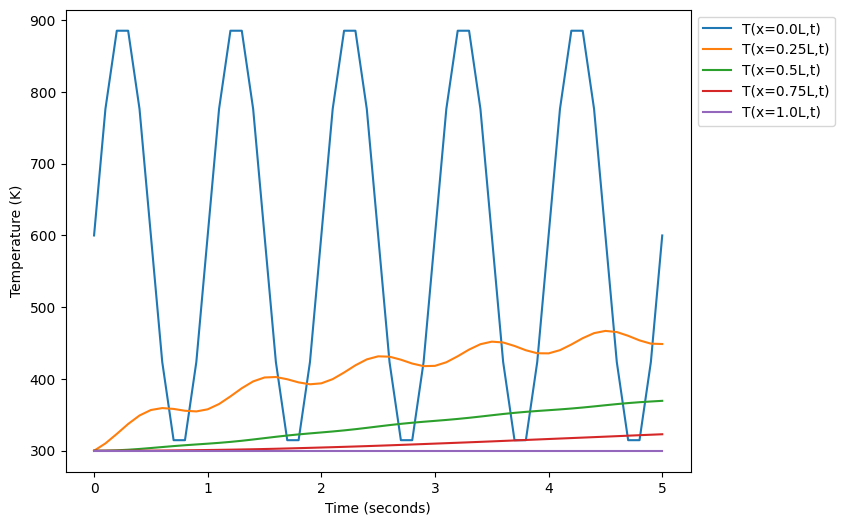

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))  # Adjusts the figure size
for i in range(T_matrix.shape[1]):
    plt.plot(t_mesh[:-1], T_matrix[:-1, i], label=f'T(x={i*0.25}L,t)')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.subplots_adjust(right=0.75)  # Adjust the right margin to make room for the legend
plt.show()

In [ ]:
T_0 = 300
w = 1
L = 0.1
Nx = 10 # Number of divisions

theta = 1  # this is the parameter value for Crank Nicholson Scheme
x_mesh = np.linspace(0, L, Nx+1)   # mesh points in space / redundant
dx = x_mesh[1] - x_mesh[0]
dt = 0.1
t_sim = 5 + dt

rho = 10500 # Please check
c_p = 235 # Please check

Nt = int(round(t_sim/float(dt)))
t_mesh = np.linspace(0, t_sim, Nt+1)   # mesh points in tim

# Representation of sparse matrix and right-hand side
diagonal = np.zeros(Nx+1)
lower    = np.zeros(Nx+1)
upper    = np.zeros(Nx+1)
b        = np.zeros(Nx+1)

# Jacobian computing

Lambda = dt/(2*rho*c_p*(dx**2))
T_matrix = np.zeros((len(t_mesh), len(x_mesh)))
T_matrix[0,0] = 2 * T_0 # x = 0, Boundary Condition
T_matrix[:, -1] = T_0
T_matrix[0,1:-1] = T_0

start_time = time.time()
for t in range(1, len(t_mesh)-1):
  T_matrix[t,0] = T_0 * (2 + np.sin(2*np.pi*w*t_mesh[t]))
  T_n = np.copy(T_matrix[t,:])

  T_n[1:-1] = np.copy(T_matrix[t-1,1:-1])
  T_matrix[t,1:-1] = np.copy(T_n[1:-1])

  for _ in range(0,3):
    for i in range(1,Nx):
      k_minus, k, k_plus, kd_minus, kd, kd_plus   = kc(T_n[i-1]),kc(T_n[i]),kc(T_n[i+1]), kc_(T_n[i-1]), kc_(T_n[i]), kc_(T_n[i+1])
      diagonal[i] = 1 - theta*Lambda*(kd*(T_n[i-1] - 2 * T_n[i] + T_n[i+1]) - (k_minus + 2*k + k_plus))
      lower[i-1] = - theta*Lambda*(kd_minus*(T_n[i-1] - T_n[i]) + (k_minus + k))
      upper[i+1] = - theta*Lambda*(kd_plus*(-T_n[i] + T_n[i+1]) + (k + k_plus))

      b[i] = - (T_n[i] - theta*Lambda*(k_minus*(T_n[i-1] - T_n[i]) + k*(T_n[i-1] - 2*T_n[i] + T_n[i+1]) + k_plus*(-T_n[i] + T_n[i+1])) \
              - T_matrix[t-1,i] - (1 - theta)*Lambda*(kc(T_matrix[t-1,i-1])*(T_matrix[t-1,i-1] - T_matrix[t-1,i]) + \
                                                    kc(T_matrix[t-1,i])*(T_matrix[t-1,i-1] - 2*T_matrix[t-1,i] + T_matrix[t-1,i+1]) + \
                                                    kc(T_matrix[t-1,i+1])*(-T_matrix[t-1,i] + T_matrix[t-1,i+1])))
    A = scipy.sparse.diags(
        diagonals=[lower[1:-2],diagonal[1:-1], upper[2:-1]],
        offsets=[-1, 0, 1],
        shape=(Nx-1, Nx-1),
        format='csr')
    # T_pr = TDMA(lower[1:-2],diagonal[1:-1], upper[2:-1], b[1:-1])
    T_pr = scipy.sparse.linalg.spsolve(A, b[1:-1])
    T_n[1:-1] = np.copy([T_dif + T_int for T_dif, T_int in zip(T_pr, T_n[1:-1])])
    # print(T_n, len(T_n))

  T_matrix[t,:] = np.copy(T_n)

# print(T_matrix[:-1,:])
end_time = time.time()  # Capture end time after the code block executes

print(f"Runtime of the program is {end_time - start_time} seconds")

Runtime of the program is 0.127183198928833 seconds


In [ ]:
# Here a = Lower Diag, b = Main Diag, c = Upper Diag, d = solution vector
def TDMA(a,b,c,d):
    n = len(d) #
    w= np.zeros(n-1,float)
    g= np.zeros(n, float)
    p = np.zeros(n,float)

    w[0] = c[0]/b[0] # q_1
    g[0] = d[0]/b[0] # p_1

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p


T_0 = 300
w = 1
L = 0.1
Nx = 4 # Number of divisions

theta = 1  # this is the parameter value for Crank Nicholson Scheme
x_mesh = np.linspace(0, L, Nx+1)   # mesh points in space / redundant
dx = x_mesh[1] - x_mesh[0]
dt = 0.1
t_sim = 5 + dt

rho = 10500 # Please check
c_p = 235 # Please check

Nt = int(round(t_sim/float(dt)))
t_mesh = np.linspace(0, t_sim, Nt+1)   # mesh points in tim

# Representation of sparse matrix and right-hand side
diagonal = np.zeros(Nx+1)
lower    = np.zeros(Nx+1)
upper    = np.zeros(Nx+1)
b        = np.zeros(Nx+1)

# Jacobian computing

Lambda = dt/(2*rho*c_p*(dx**2))
T_matrix = np.zeros((len(t_mesh), len(x_mesh)))
T_matrix[0,0] = 2 * T_0 # x = 0, Boundary Condition
T_matrix[:, -1] = T_0
T_matrix[0,1:-1] = T_0

start_time = time.time()
for t in range(1, len(t_mesh)-1):
  T_matrix[t,0] = T_0 * (2 + np.sin(2*np.pi*w*t_mesh[t]))
  T_n = np.copy(T_matrix[t,:])

  T_n[1:-1] = np.copy(T_matrix[t-1,1:-1])
  T_matrix[t,1:-1] = np.copy(T_n[1:-1])

  for _ in range(0,3):
    for i in range(1,Nx):
      k_minus, k, k_plus, kd_minus, kd, kd_plus   = kc(T_n[i-1]),kc(T_n[i]),kc(T_n[i+1]), kc_(T_n[i-1]), kc_(T_n[i]), kc_(T_n[i+1])
      diagonal[i] = 1 - theta*Lambda*(kd*(T_n[i-1] - 2 * T_n[i] + T_n[i+1]) - (k_minus + 2*k + k_plus))
      lower[i-1] = - theta*Lambda*(kd_minus*(T_n[i-1] - T_n[i]) + (k_minus + k))
      upper[i+1] = - theta*Lambda*(kd_plus*(-T_n[i] + T_n[i+1]) + (k + k_plus))

      b[i] = - (T_n[i] - theta*Lambda*(k_minus*(T_n[i-1] - T_n[i]) + k*(T_n[i-1] - 2*T_n[i] + T_n[i+1]) + k_plus*(-T_n[i] + T_n[i+1])) \
              - T_matrix[t-1,i] - (1 - theta)*Lambda*(kc(T_matrix[t-1,i-1])*(T_matrix[t-1,i-1] - T_matrix[t-1,i]) + \
                                                    kc(T_matrix[t-1,i])*(T_matrix[t-1,i-1] - 2*T_matrix[t-1,i] + T_matrix[t-1,i+1]) + \
                                                    kc(T_matrix[t-1,i+1])*(-T_matrix[t-1,i] + T_matrix[t-1,i+1])))

    T_pr = TDMA(lower[1:-2],diagonal[1:-1], upper[2:-1], b[1:-1])

    T_n[1:-1] = np.copy([T_dif + T_int for T_dif, T_int in zip(T_pr, T_n[1:-1])])
    # print(T_n, len(T_n))

  T_matrix[t,:] = np.copy(T_n)

# print(T_matrix[:-1,:])
end_time = time.time()  # Capture end time after the code block executes

print(f"Runtime of the program is {end_time - start_time} seconds")

Runtime of the program is 0.028053760528564453 seconds


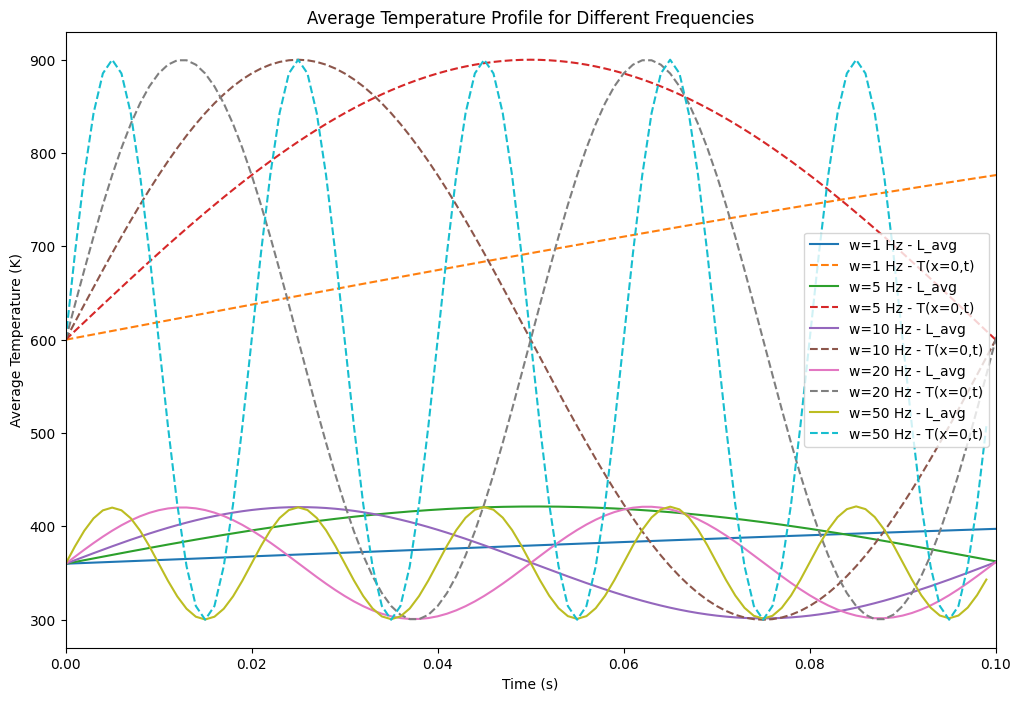

In [ ]:
def run_simulation(w):
    T_0 = 300
    L = 0.1
    Nx = 4  # Number of divisions

    theta = 1  # Parameter for Crank-Nicolson scheme
    dx = L / Nx
    dt = 0.001
    cycles = 5
    t_sim = cycles / w  # Adjust simulation time based on w to cover 5 cycles

    rho = 10500  # Density (kg/m^3), please verify
    c_p = 235  # Specific heat capacity (J/kg.K), please verify

    Nt = int(t_sim / dt)  # Number of time steps
    t_mesh = np.linspace(0, t_sim, Nt + 1)  # Mesh points in time

    Lambda = dt / (2 * rho * c_p * (dx ** 2))
    T_matrix = np.zeros((Nt + 1, Nx + 1))
    T_matrix[0, 0] = 2 * T_0  # Boundary condition at x=0
    T_matrix[:, -1] = T_0  # Boundary condition at x=L
    T_matrix[0, 1:-1] = T_0  # Initial condition

    for t in range(1, Nt):
        T_matrix[t,0] = T_0 * (2 + np.sin(2*np.pi*w*t_mesh[t]))
        T_n = np.copy(T_matrix[t,:])

        T_n[1:-1] = np.copy(T_matrix[t-1,1:-1])
        T_matrix[t,1:-1] = np.copy(T_n[1:-1])

        for _ in range(0,3):
            for i in range(1,Nx):
              k_minus, k, k_plus, kd_minus, kd, kd_plus   = kc(T_n[i-1]),kc(T_n[i]),kc(T_n[i+1]), kc_(T_n[i-1]), kc_(T_n[i]), kc_(T_n[i+1])
              diagonal[i] = 1 - theta*Lambda*(kd*(T_n[i-1] - 2 * T_n[i] + T_n[i+1]) - (k_minus + 2*k + k_plus))
              lower[i-1] = - theta*Lambda*(kd_minus*(T_n[i-1] - T_n[i]) + (k_minus + k))
              upper[i+1] = - theta*Lambda*(kd_plus*(-T_n[i] + T_n[i+1]) + (k + k_plus))

              b[i] = - (T_n[i] - theta*Lambda*(k_minus*(T_n[i-1] - T_n[i]) + k*(T_n[i-1] - 2*T_n[i] + T_n[i+1]) + k_plus*(-T_n[i] + T_n[i+1])) \
                        - T_matrix[t-1,i] - (1 - theta)*Lambda*(kc(T_matrix[t-1,i-1])*(T_matrix[t-1,i-1] - T_matrix[t-1,i]) + \
                                                    kc(T_matrix[t-1,i])*(T_matrix[t-1,i-1] - 2*T_matrix[t-1,i] + T_matrix[t-1,i+1]) + \
                                                    kc(T_matrix[t-1,i+1])*(-T_matrix[t-1,i] + T_matrix[t-1,i+1])))

            T_pr = TDMA(lower[1:-2],diagonal[1:-1], upper[2:-1], b[1:-1])

            T_n[1:-1] = np.copy([T_dif + T_int for T_dif, T_int in zip(T_pr, T_n[1:-1])])
    # print(T_n, len(T_n))

        T_matrix[t,:] = np.copy(T_n)

    # After simulation code
    return t_mesh, T_matrix

# List of w values to simulate
w_values = [1, 5, 10, 20, 50]

# Run simulation for each w and plot
plt.figure(figsize=(12, 8))

for w in w_values:
    # start_time = time.time()
    t_mesh, T_matrix = run_simulation(w)
    boundary_x_0 = T_0 * (2 + np.sin(2*np.pi*w*t_mesh[:-1]))
    length_average_T = np.mean(T_matrix[:-1,:], axis=1)
    plt.plot(t_mesh[:-1], length_average_T, label=f'w={w} Hz - L_avg')
    plt.plot(t_mesh[:-1], boundary_x_0, label=f'w={w} Hz - T(x=0,t)',linestyle='--')

    # print(f'Simulation for w={w} Hz completed in {time.time() - start_time:.2f} seconds.')

plt.xlabel('Time (s)')
plt.ylabel('Average Temperature (K)')
plt.title('Average Temperature Profile for Different Frequencies')
plt.xlim(0,0.1)
plt.legend()
plt.show()

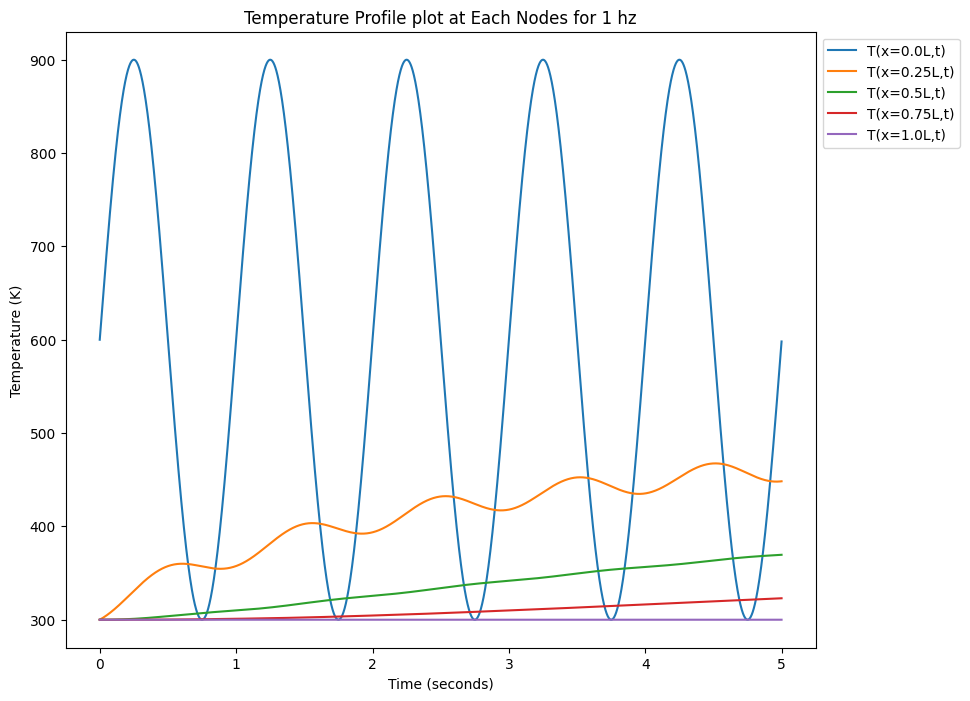

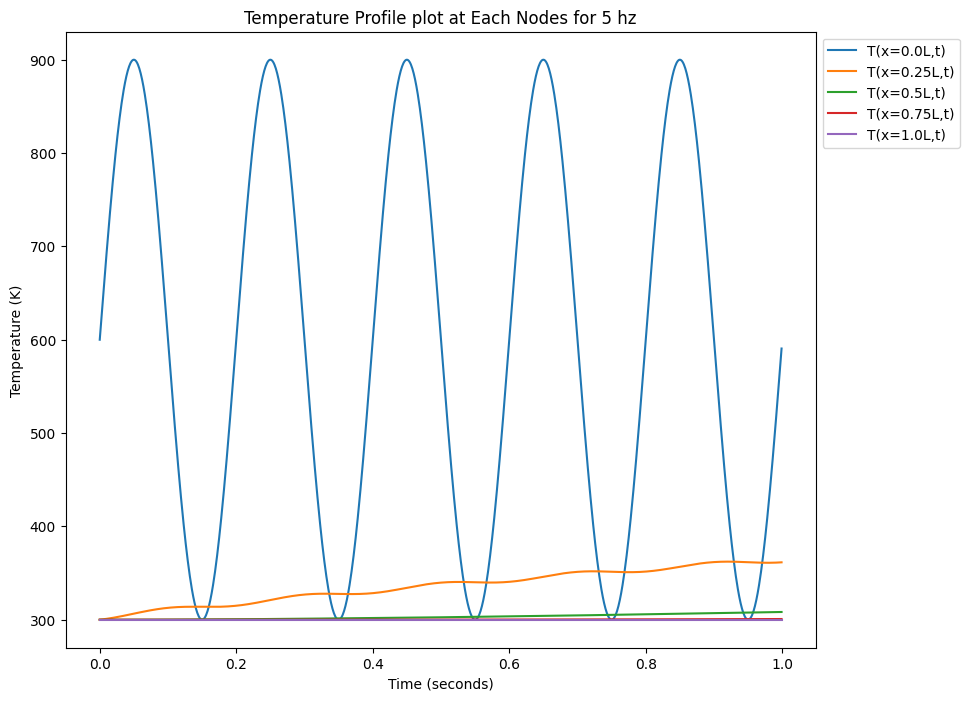

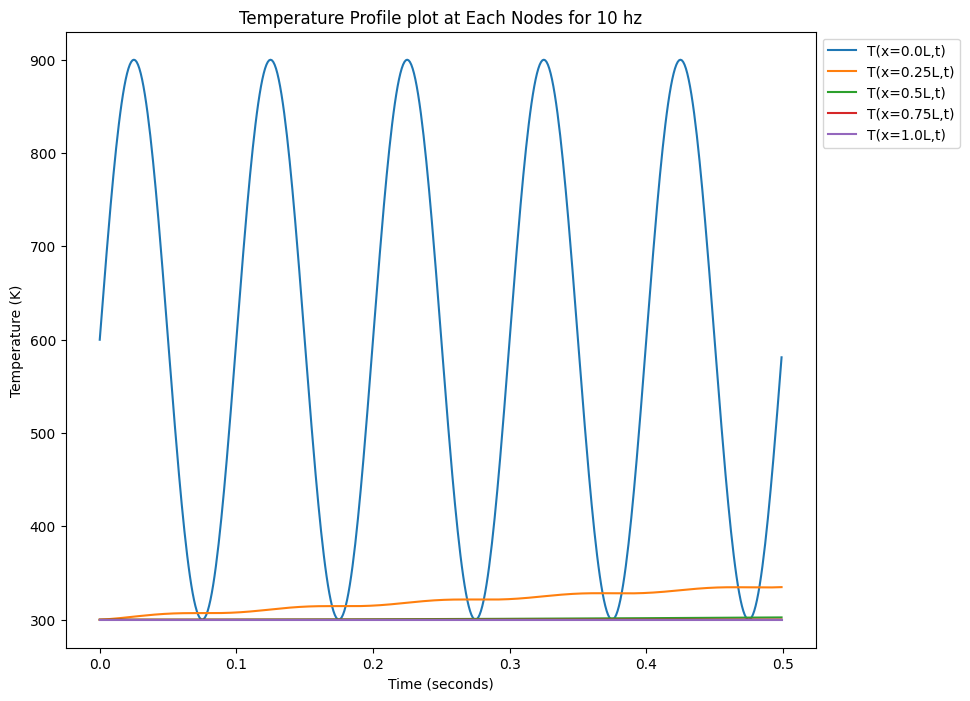

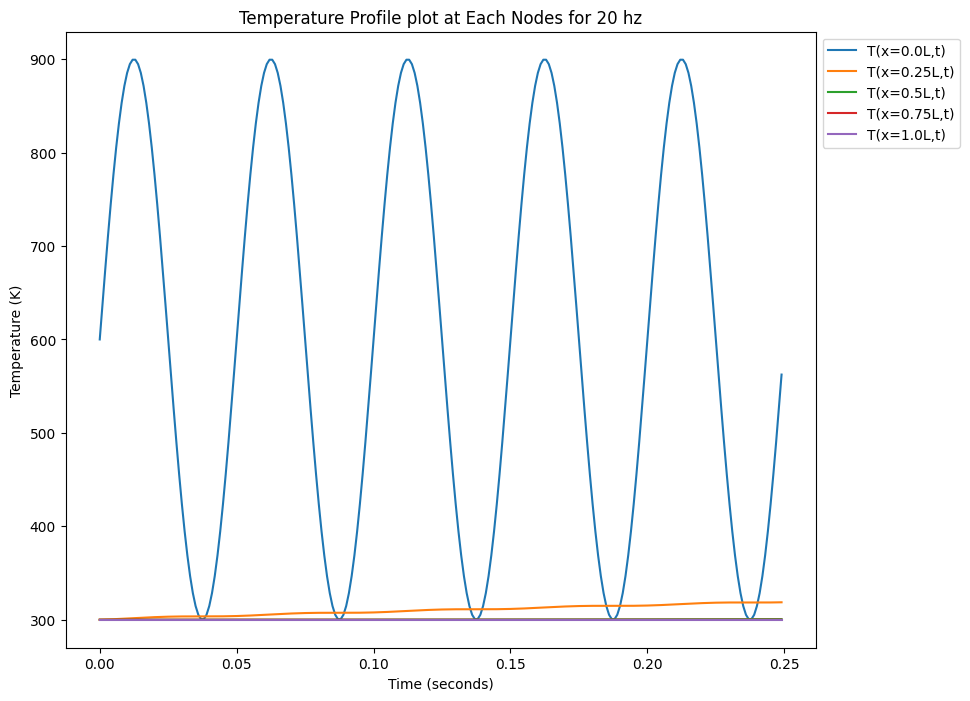

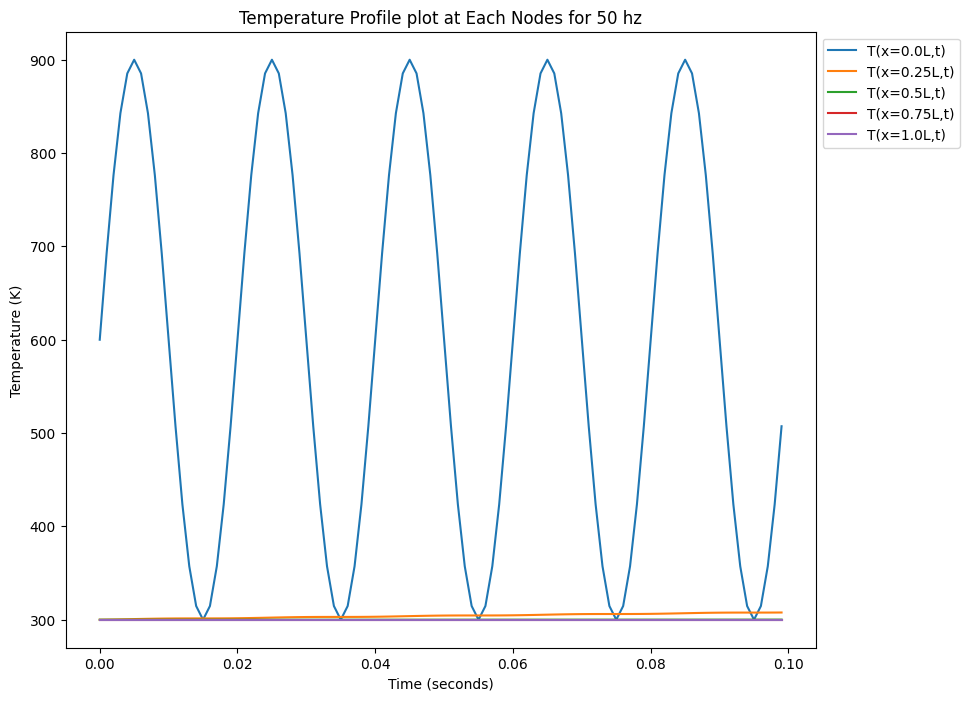

In [ ]:
# List of w values to simulate
w_values = [1, 5, 10, 20, 50]

# Run simulation for each w and plot

for w in w_values:
    t_mesh, T_matrix = run_simulation(w)
    # Plotting
    plt.figure(figsize=(12, 8))
    for i in range(T_matrix.shape[1]):
        plt.plot(t_mesh[:-1], T_matrix[:-1, i], label=f'T(x={i*0.25}L,t)')

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(f'Temperature Profile plot at Each Nodes for {w} hz')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Temperature (K)')
    plt.subplots_adjust(right=0.75)  # Adjust the right margin to make room for the legend
    plt.show()